In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import scipy
import empiricaldist
import statsmodels.api as sm
import statsmodels.formula.api as smf

s = plt.show()

# Extract

## Data Extracted from a Postgres DB

In [2]:
connect = psycopg2.connect(f"dbname='' user='' password='' host='localhost'")

In [3]:
cursor = connect.cursor()

In [4]:
cursor.execute('SELECT * FROM aigda;')
data = cursor.fetchall()

In [5]:
cursor.close()

In [6]:
for d in data:
    print(d)

(1, datetime.datetime(2022, 3, 16, 19, 8), 'Sad', 4, 160, 'in range')
(2, datetime.datetime(2022, 3, 17, 8, 34), 'Normal', 7, 200, 'High')
(3, datetime.datetime(2022, 3, 17, 17, 56), 'Tired', 4, 125, 'in range')
(4, datetime.datetime(2022, 3, 18, 17, 11), 'Tired', 5, 89, 'in range')
(5, datetime.datetime(2022, 3, 18, 20, 0), 'Hungry', 8, 170, 'in range')
(6, datetime.datetime(2022, 3, 18, 23, 32), 'Motivated', 2, 80, 'in range')
(7, datetime.datetime(2022, 3, 19, 14, 0), 'Normal', 5, 96, 'in range')
(8, datetime.datetime(2022, 3, 20, 12, 9), 'Normal', 5, 200, 'High')
(9, datetime.datetime(2022, 3, 21, 21, 2), 'Stress ', 9, 130, 'in range')
(10, datetime.datetime(2022, 3, 22, 8, 48), 'Stress', 9, 170, 'in range')
(11, datetime.datetime(2022, 3, 22, 12, 15), 'Relaxed ', 4, 112, 'in range')
(12, datetime.datetime(2022, 4, 13, 14, 33), 'Normal', 1, 89, 'in range')
(13, datetime.datetime(2022, 4, 13, 19, 0), 'Normal', 0, 150, 'in range')
(14, datetime.datetime(2022, 4, 14, 7, 50), 'Normal',

## Creating Dataframe

In [7]:
original_df = pd.DataFrame(data, columns=['Id', 'Register_DT', 'Mood', 'Anxiety_Level', 'Glucose', 'G_Level'])
original_df.drop(['Id'], axis=1, inplace=True)
original_df.sample(5)

,Register_DT,Mood,Anxiety_Level,Glucose,G_Level
64,2022-05-16 11:40:00,Normal,0,115,in range
211,2022-08-13 07:30:00,Normal,2,89,in range
133,2022-06-24 02:30:00,Relaxed,0,86,in range
261,2022-10-27 00:50:00,Normal,0,139,in range
49,2022-06-05 11:27:00,Normal,0,97,in range


In [8]:
df = original_df.copy()
df.sample(5)

,Register_DT,Mood,Anxiety_Level,Glucose,G_Level
73,2022-05-22 13:00:00,Angry,4,129,in range
76,2022-05-25 09:58:00,Normal,2,65,Low
112,2022-06-16 13:43:00,Normal,0,123,in range
191,2022-07-25 16:30:00,Normal,2,101,in range
179,2022-11-07 14:08:00,Normal,2,91,in range


## Data Validation

In [9]:
df.shape

(282, 5)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Register_DT    282 non-null    datetime64[ns]
 1   Mood           282 non-null    object        
 2   Anxiety_Level  282 non-null    int64         
 3   Glucose        282 non-null    int64         
 4   G_Level        282 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.1+ KB


In [11]:
df.isna().sum().sum()

0

In [12]:
df.dtypes.value_counts()

object            2
int64             2
datetime64[ns]    1
dtype: int64

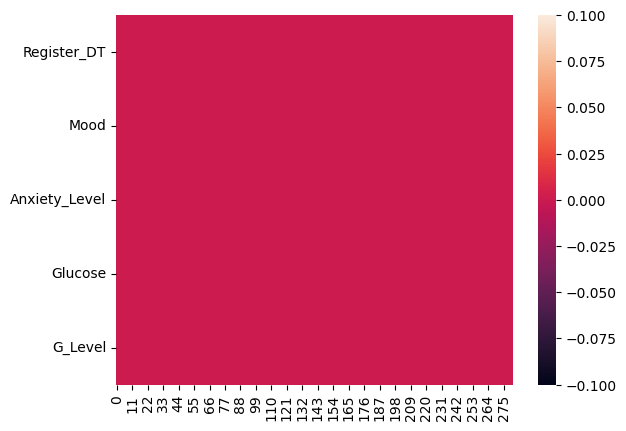

In [13]:
sns.heatmap(df.isnull().transpose())
s

# EDA

## Diagnostic Analysis

In [14]:
df.describe(include=object)

,Mood,G_Level
count,282,282
unique,12,4
top,Normal,in range
freq,215,249


In [15]:
df.describe()

,Anxiety_Level,Glucose
count,282.000000,282.000000
mean,1.127660,120.971631
std,1.697187,33.074152
min,0.000000,60.000000
25%,0.000000,100.000000
50%,0.000000,116.000000
75%,2.000000,135.000000
max,9.000000,275.000000


In [16]:
df.loc[(df['Anxiety_Level'] <=2) & (df['Glucose'] <= 135)].describe(include=object)

,Mood,G_Level
count,196,196
unique,5,3
top,Normal,in range
freq,157,181


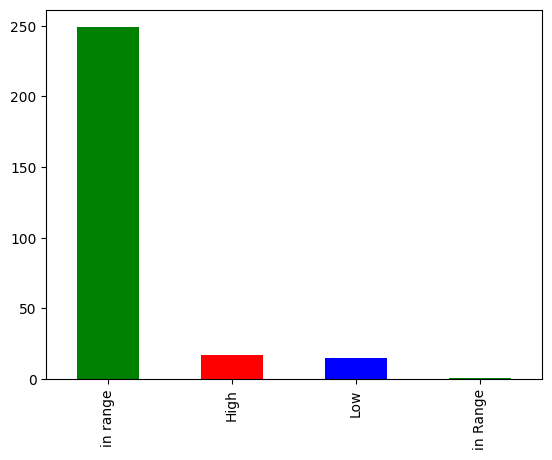

In [17]:
df.G_Level.value_counts().plot(kind='bar', color=['g', 'r', 'b'])
s

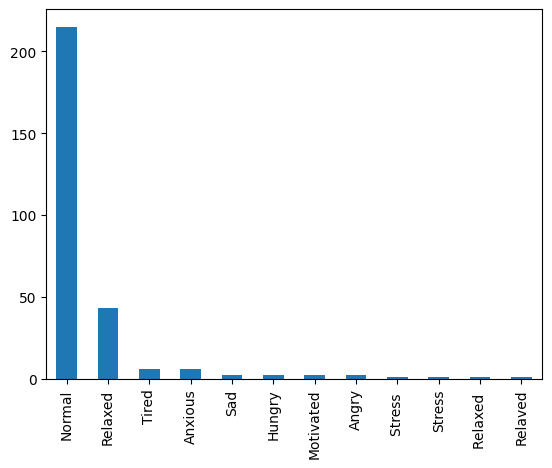

In [18]:
df.Mood.value_counts().plot(kind='bar')
s

In [19]:
df.Mood = df.Mood.replace(" ", "")
df.Mood = df.Mood.replace('Relaved', 'Relaxed')
df.Mood = df.Mood.replace('Relaxed ', 'Relaxed')
df.Mood = df.Mood.replace('Stress ', 'Stress')

In [20]:
df.Mood.unique()

array(['Sad', 'Normal', 'Tired', 'Hungry', 'Motivated', 'Stress',
       'Relaxed', 'Anxious', 'Angry'], dtype=object)

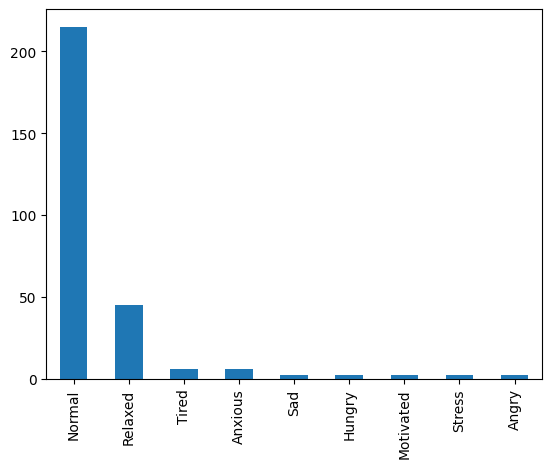

In [21]:
df.Mood.value_counts().plot(kind='bar')
s

In [22]:
(
  df.astype({
    'Mood': 'category',
    'G_Level': 'category'
})
)

,Register_DT,Mood,Anxiety_Level,Glucose,G_Level
0,2022-03-16 19:08:00,Sad,4,160,in range
1,2022-03-17 08:34:00,Normal,7,200,High
2,2022-03-17 17:56:00,Tired,4,125,in range
3,2022-03-18 17:11:00,Tired,5,89,in range
4,2022-03-18 20:00:00,Hungry,8,170,in range
...,...,...,...,...,...
277,2022-11-30 07:01:00,Normal,0,124,in range
278,2022-11-30 11:02:00,Normal,0,139,in range
279,2022-11-30 13:16:00,Normal,0,158,in range
280,2022-11-30 19:31:00,Normal,0,154,in range


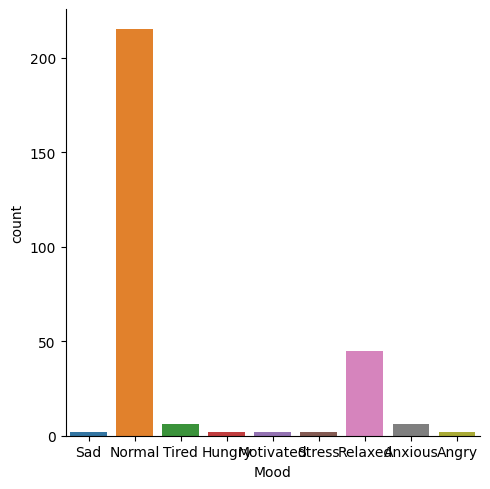

In [23]:
sns.catplot(data=df, x='Mood', kind='count')
s

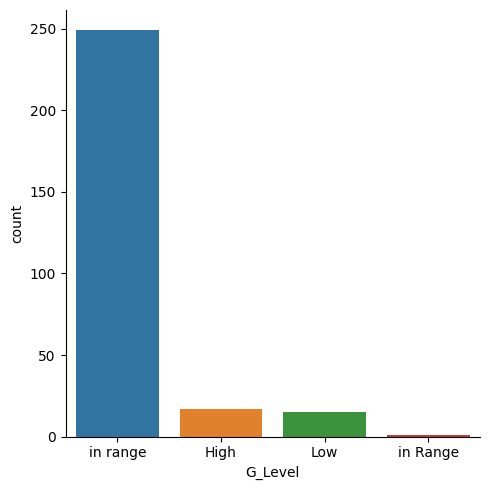

In [24]:
sns.catplot(data=df, x='G_Level', kind='count')
s

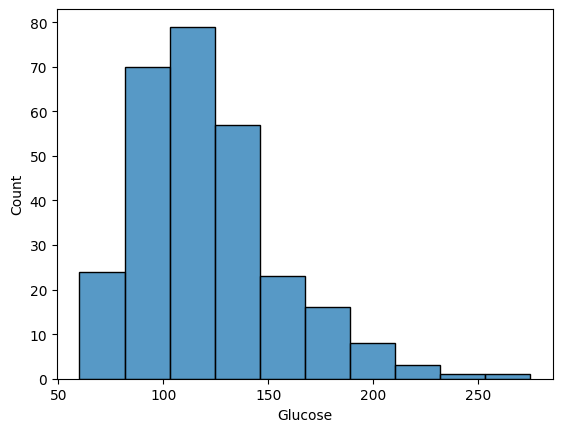

In [25]:
sns.histplot(df.Glucose, bins=10) 
s

<AxesSubplot: xlabel='Anxiety_Level', ylabel='Count'>

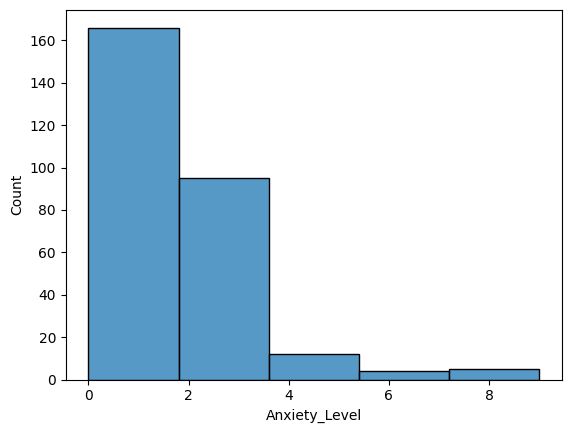

In [26]:
sns.histplot(df.Anxiety_Level, bins=5)

## Descriptive Analysis

### Measures of Central Tendency

In [27]:
print(f'The mean of glucose is {round(df.Glucose.mean(), 2)}')
print(f'The median of glucose is {round(np.median(df.Glucose), 2)}')
print(f'The standard deviation of glucose is {round(df.Glucose.std(), 2)}')

The mean of glucose is 120.97
The median of glucose is 116.0
The standard deviation of glucose is 33.07


In [28]:
print(f'The mean of anxiety level is {round(df.Anxiety_Level.mean(), 2)}')
print(f'The median of anxiety level is {round(np.median(df.Anxiety_Level), 2)}')
print(f'The standard deviation of anxiety level is {round(df.Anxiety_Level.std(), 2)}')

The mean of anxiety level is 1.13
The median of anxiety level is 0.0
The standard deviation of anxiety level is 1.7


In [29]:
df[['Glucose', 'Mood', 'Anxiety_Level', 'G_Level']].mode()

,Glucose,Mood,Anxiety_Level,G_Level
0,100,Normal,0,in range


### Distribution Indicators

In [30]:
max_values = df[['Glucose', 'Anxiety_Level']].max()
max_values

Glucose          275
Anxiety_Level      9
dtype: int64

In [31]:
min_values = df[['Glucose', 'Anxiety_Level']].min()
min_values

Glucose          60
Anxiety_Level     0
dtype: int64

In [32]:
values_range  = max_values - min_values
values_range

Glucose          215
Anxiety_Level      9
dtype: int64

In [33]:
q3 = df[['Glucose', 'Anxiety_Level']].quantile(0.75)
q1 = df[['Glucose', 'Anxiety_Level']].quantile(0.25)
iq = q3 - q1

# Interquartile Range
iq

Glucose          35.0
Anxiety_Level     2.0
dtype: float64

In [34]:
(df[['Glucose', 'Anxiety_Level']].quantile([0.25, 0.50, 0.75])
  .transpose().rename_axis('variable').reset_index().assign(
      iqr = lambda df: df[0.75] - df[0.25]
  )
 )

,variable,0.25,0.5,0.75,iqr
0,Glucose,100.0,116.0,135.0,35.0
1,Anxiety_Level,0.0,0.0,2.0,2.0


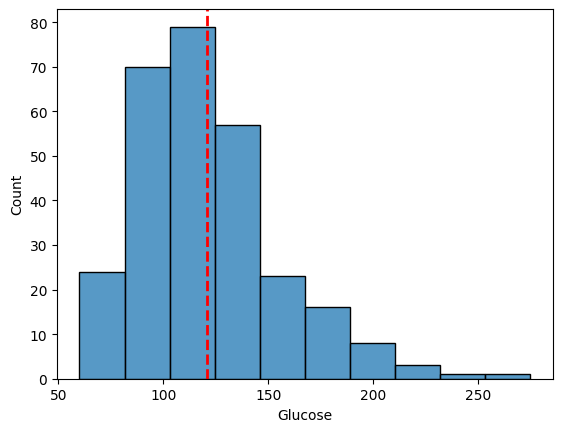

In [35]:
sns.histplot(data=df, x='Glucose', bins=10)
plt.axvline(df.Glucose.mean(), color='r', linestyle='dashed', linewidth=2)
s

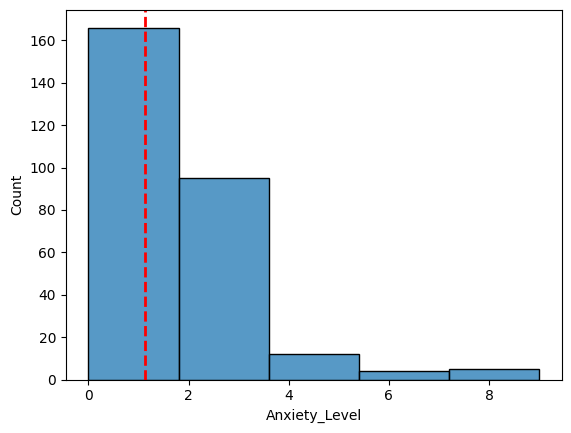

In [36]:
sns.histplot(data=df, x='Anxiety_Level', bins=5)
plt.axvline(df.Anxiety_Level.mean(), color='r', linestyle='dashed', linewidth=2)
s

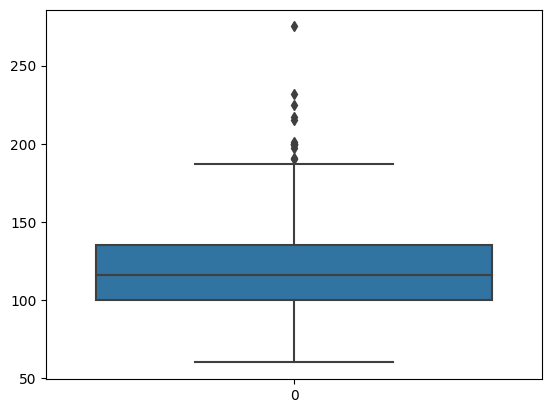

In [37]:
sns.boxplot(df.Glucose)
s

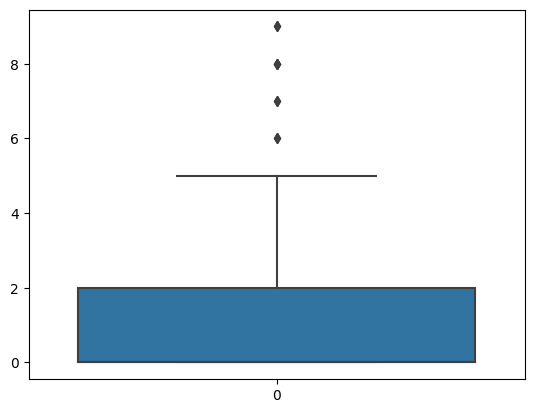

In [38]:
sns.boxplot(df.Anxiety_Level)
s

### Probability Distribution

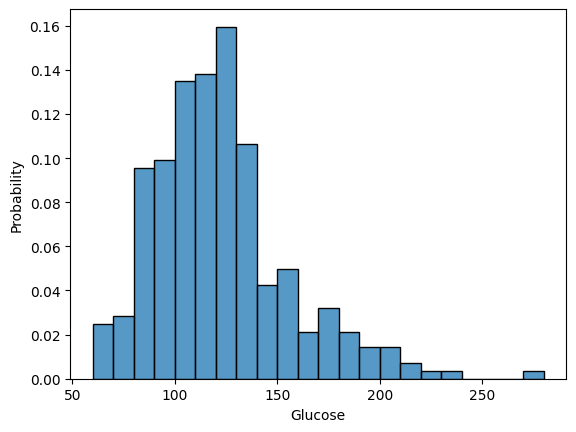

In [39]:
# Mass probability
sns.histplot(data=df, x='Glucose', binwidth=10, stat='probability')
s

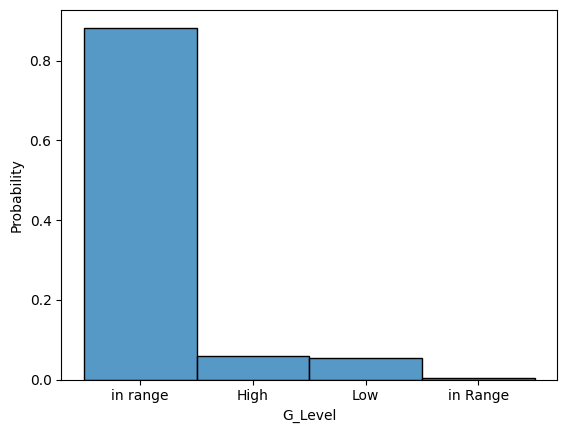

In [40]:
sns.histplot(data=df, x='G_Level', stat='probability')
s

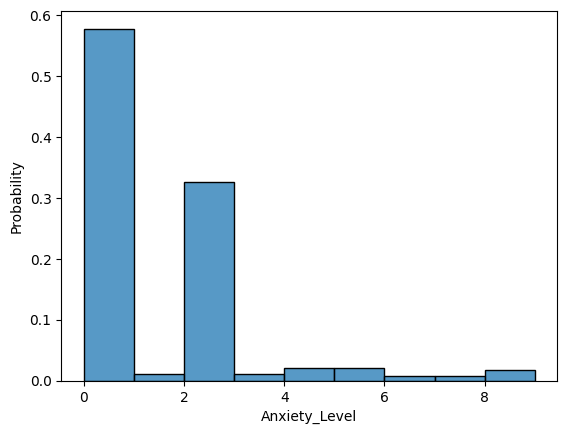

In [41]:
sns.histplot(data=df, x='Anxiety_Level', binwidth=1, stat='probability')
s

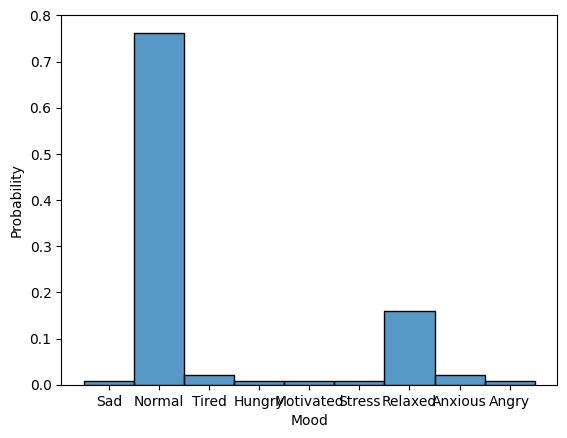

In [42]:
sns.histplot(data=df, x='Mood', stat='probability')
s

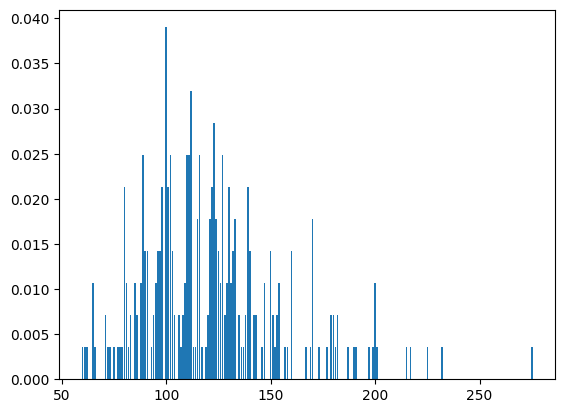

In [43]:
# PMF
pmf_glucose = empiricaldist.Pmf.from_seq(df.Glucose, normalize=True)
pmf_glucose.bar()
s

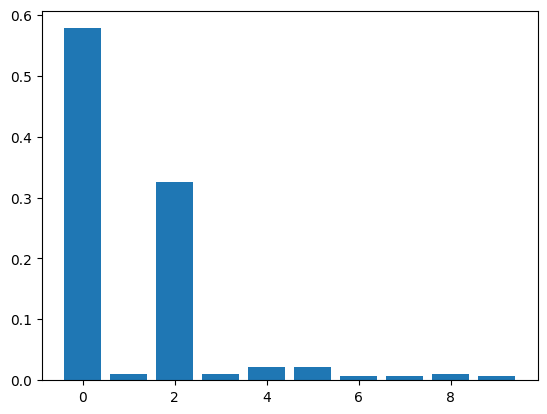

In [44]:
pmf_al = empiricaldist.Pmf.from_seq(df.Anxiety_Level, normalize=True)
pmf_al.bar()

In [45]:
print(f'The probability of my blood sugar level will be 90 mg/dl is {(pmf_glucose(90)*100)}%')

The probability of my blood sugar level will be 90 mg/dl is 1.4184397163120568%


In [46]:
print(f'The probability of my anxiety level will be 9 is {(pmf_al(9)*100)}%')

The probability of my anxiety level will be 9 is 0.7092198581560284%


In [47]:
print(f'pmf glucose {pmf_glucose.max()*100}%\npmf anxiety level: {pmf_al.max()*100}%')

pmf glucose 3.900709219858156%
pmf anxiety level: 57.801418439716315%


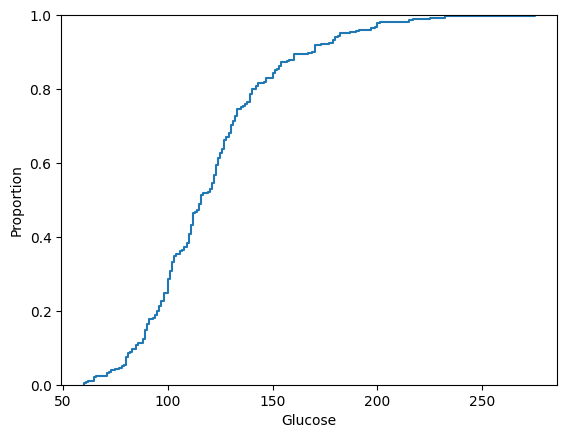

In [48]:
# That or less probability
sns.ecdfplot(data=df, x='Glucose')
s

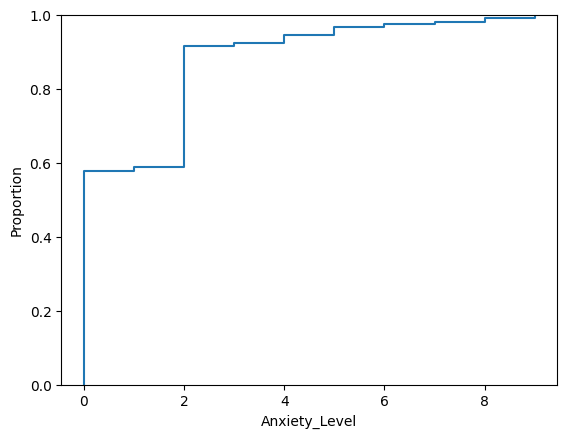

In [49]:
# That or less probability
sns.ecdfplot(data=df, x='Anxiety_Level')
s

In [50]:
#Cumulative Probability
cdf_g = empiricaldist.Cdf.from_seq(df.Glucose, normalize=True)
cdf_al = empiricaldist.Cdf.from_seq(df.Anxiety_Level, normalize=True)

In [51]:
print(f'Probability of me having a bloood sugar level of 120 mg/dl or less is {(cdf_g(120)*100)}%')
print(f'Probability of me with an Anxiety level of 4 or less is {(cdf_al(4)*100)}%')

Probability of me having a bloood sugar level of 120 mg/dl or less is 52.836879432624116%
Probability of me with an Anxiety level of 4 or less is 94.68085106382979%


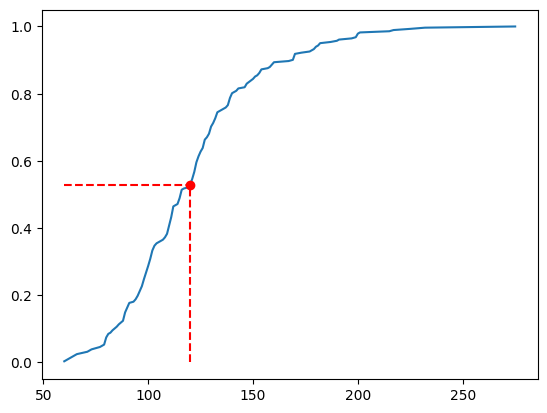

In [52]:
cdf_g.plot()

q=120
p=cdf_g.forward(q)

plt.vlines(
    x=q,
    ymin=0, ymax=p,
    color='red', linestyle='dashed'
)

plt.hlines(
    y=p,
    xmin=pmf_glucose.qs[0], xmax=q,
    color='red', linestyle='dashed'
)

plt.plot(q, p, 'ro')
s

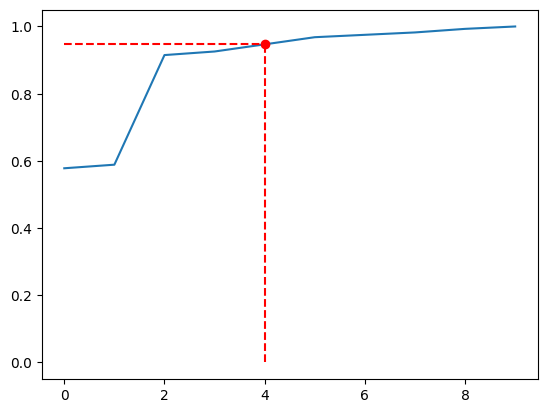

In [53]:
cdf_al.plot()

q=4
p=cdf_al.forward(q)

plt.vlines(
    x=q,
    ymin=0, ymax=p,
    color='red', linestyle='dashed'
)

plt.hlines(
    y=p,
    xmin=pmf_al.qs[0], xmax=q,
    color='red', linestyle='dashed'
)

plt.plot(q, p, 'ro')
s

In [54]:
print(f'Probability of finding a glucose level under the 1Q: {cdf_g.inverse(.25)}%')
print(f'Probability of finding an anxiety level under the 3Q: {cdf_al.inverse(.75)}%')

Probability of finding a glucose level under the 1Q: 100.0%
Probability of finding an anxiety level under the 3Q: 2.0%


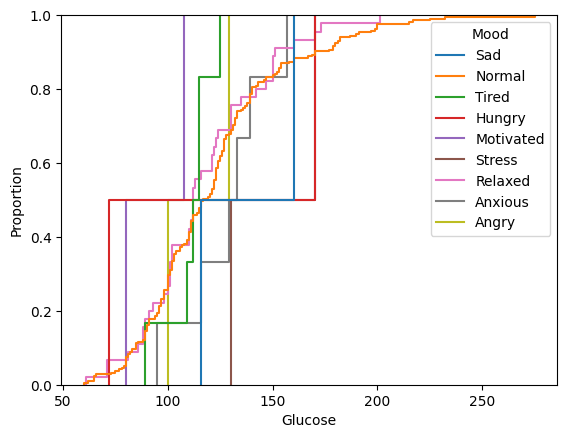

In [55]:
# Note: I need more data to see this plot working effectively
sns.ecdfplot(data=df, x='Glucose', hue='Mood')
s

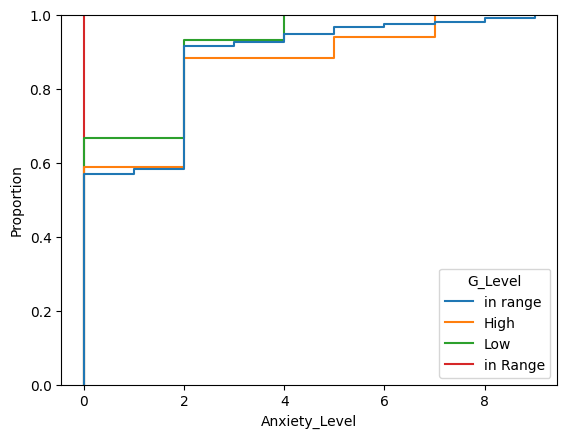

In [56]:
sns.ecdfplot(data=df, x='Anxiety_Level', hue='G_Level')
s

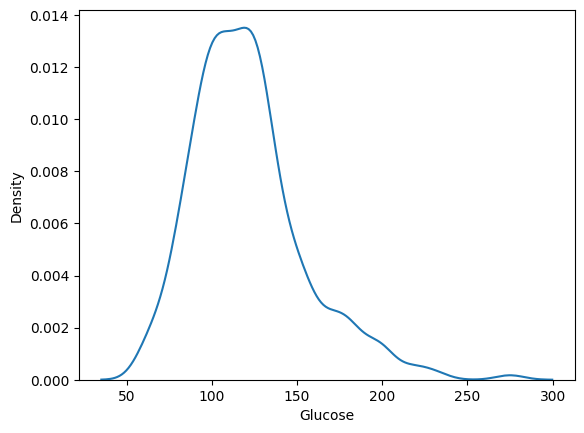

In [57]:
# Density probability
sns.kdeplot(data=df, x='Glucose', bw_method=0.25)
s

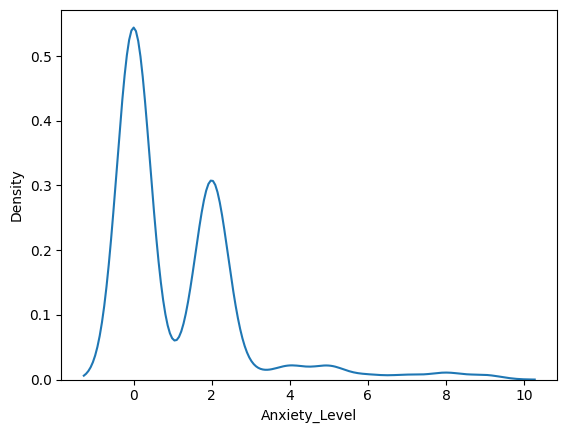

In [58]:
# Density probability
sns.kdeplot(data=df, x='Anxiety_Level', bw_method=0.25)
s

In [59]:
g_stats = df.Glucose.describe()
xs = np.linspace(g_stats['min'], g_stats['max'])
ys = scipy.stats.norm(g_stats['mean'], g_stats['std']).cdf(xs)

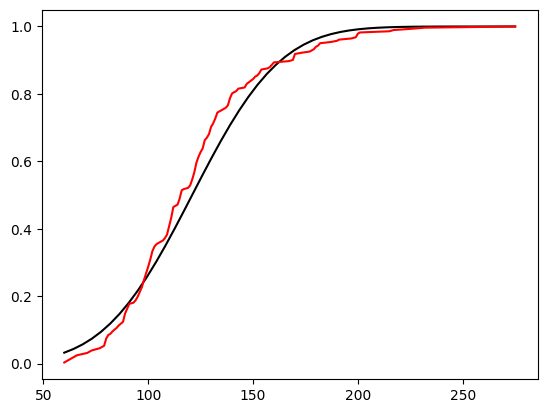

In [60]:
plt.plot(xs, ys, color='black')
empiricaldist.Cdf.from_seq(df.Glucose, normalize=True).plot(color='r')
s

## Relationship Analysis

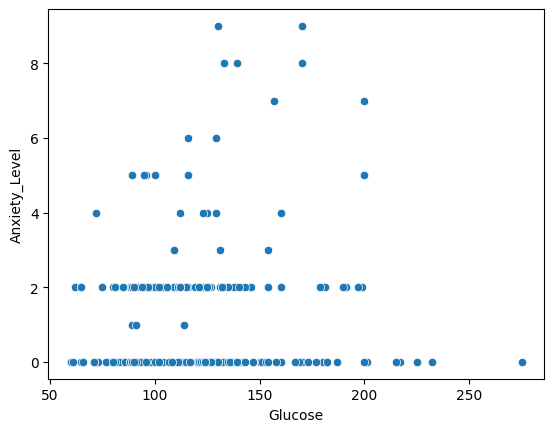

In [64]:
sns.scatterplot(data=df, x='Glucose', y='Anxiety_Level')
s

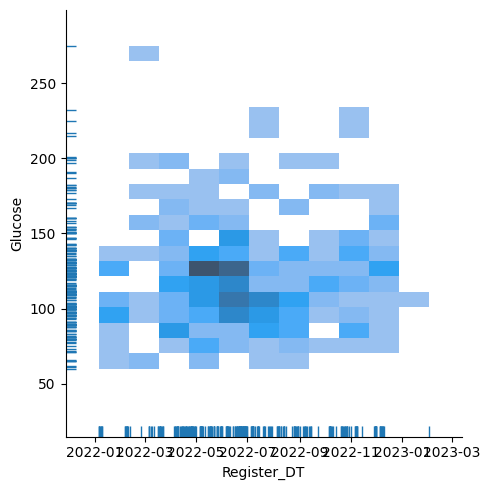

In [68]:
sns.displot(data=df, x='Register_DT', y='Glucose', rug=True)
s

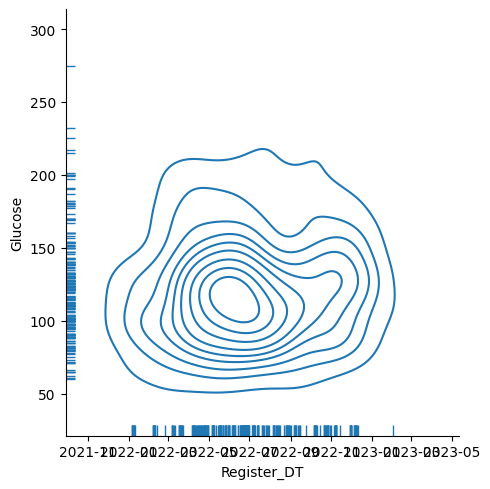

In [69]:
sns.displot(data=df, x='Register_DT', y='Glucose', rug=True, kind='kde')
s

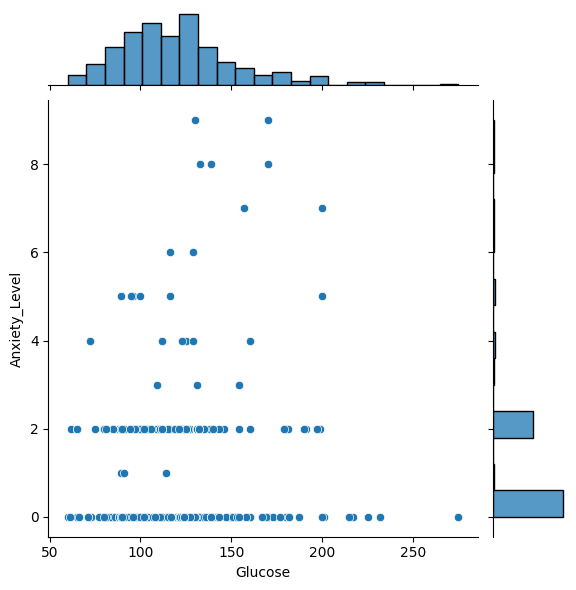

In [72]:
sns.jointplot(data=df, x='Glucose', y='Anxiety_Level')
s

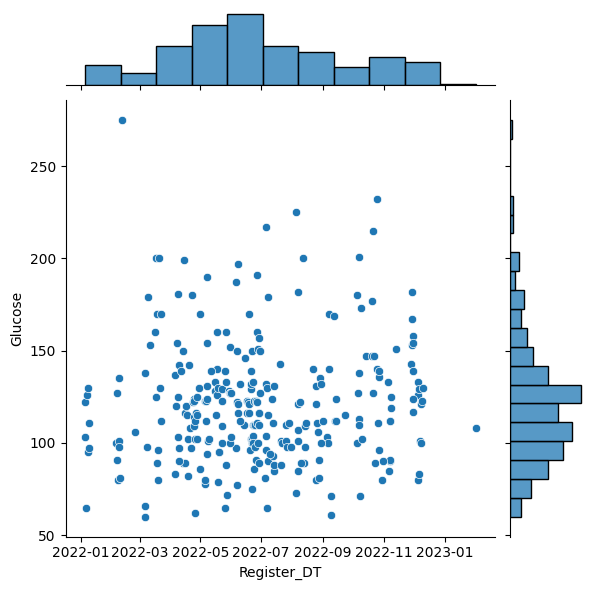

In [74]:
sns.jointplot(data=df, x='Register_DT', y='Glucose')
s

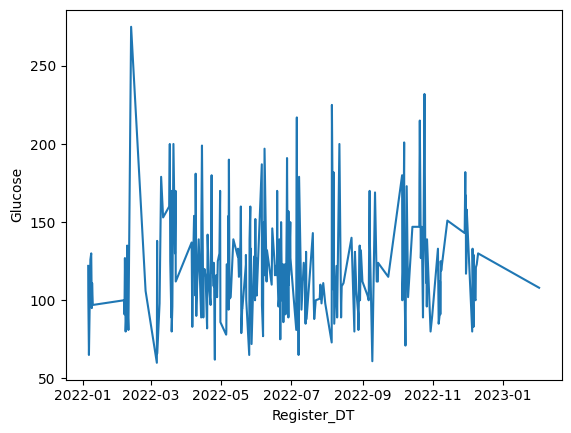

In [75]:
sns.lineplot(data=df, x='Register_DT', y='Glucose')
s

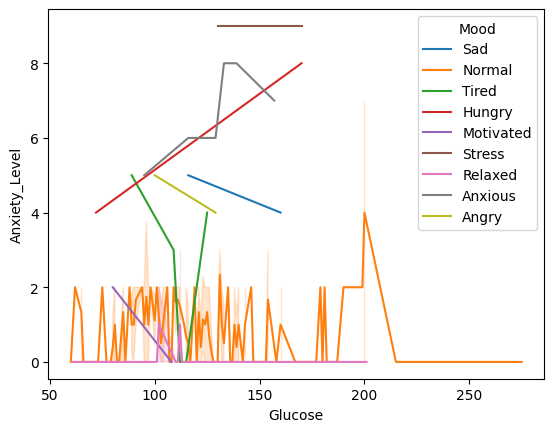

In [76]:
sns.lineplot(data=df, x='Glucose', y='Anxiety_Level', hue='Mood')
s

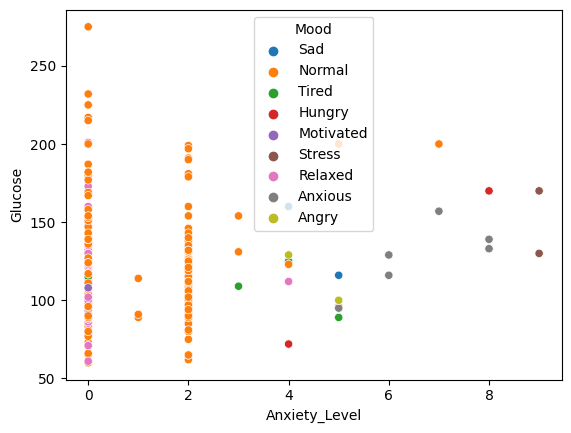

In [83]:
sns.scatterplot(data=df, x='Anxiety_Level', y='Glucose', hue='Mood')
s

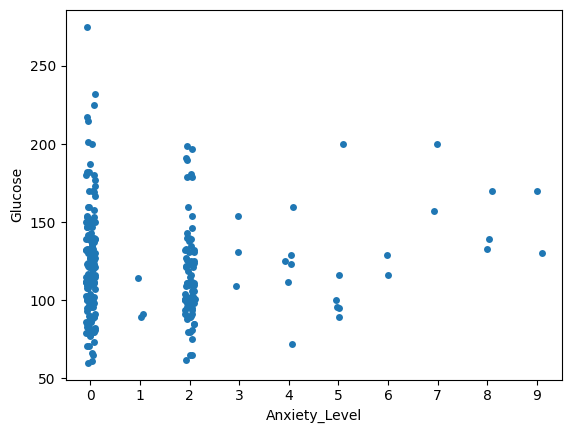

In [82]:
sns.stripplot(data=df, x='Anxiety_Level', y='Glucose')
s

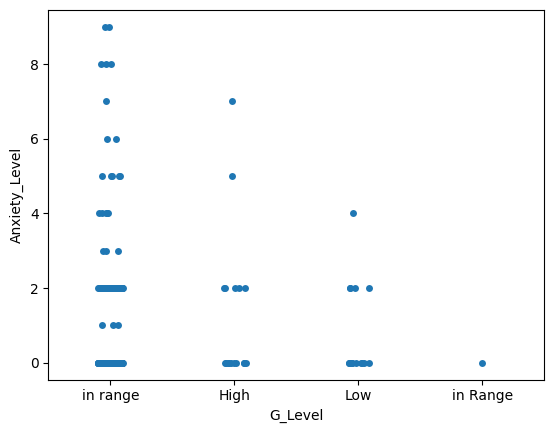

In [84]:
sns.stripplot(data=df, x='G_Level', y='Anxiety_Level')
s

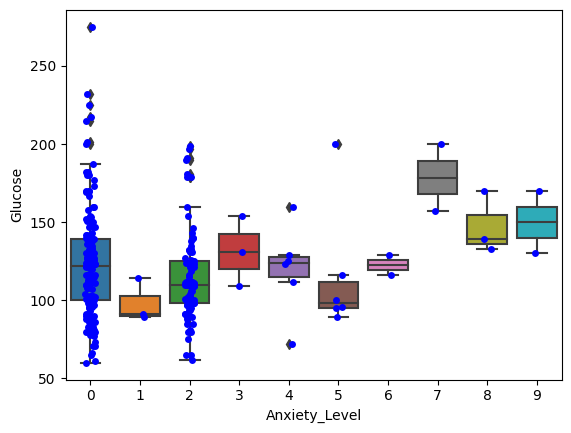

In [86]:
ax = sns.boxplot(data=df, x='Anxiety_Level', y='Glucose')
ax = sns.stripplot(data=df, x='Anxiety_Level', y='Glucose', color='b')
s

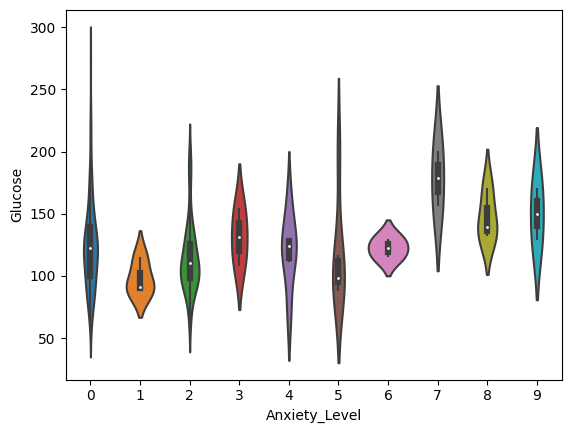

In [88]:
sns.violinplot(data=df, x='Anxiety_Level', y='Glucose')
s

c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\seaborn\categorical.py:3543: UserWarning: 33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\seaborn\categorical.py:3543: UserWarning: 27.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\seaborn\categorical.py:3543: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


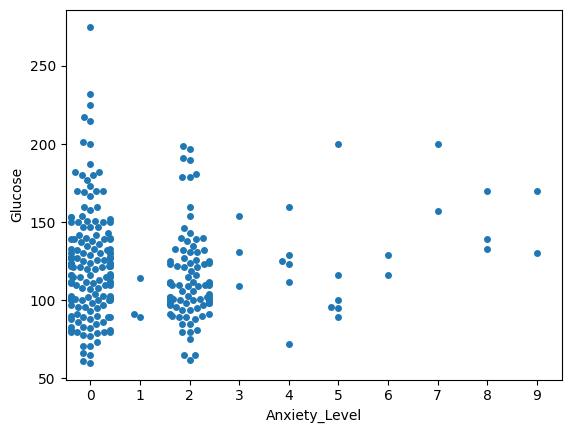

In [89]:
sns.swarmplot(data=df, x='Anxiety_Level', y='Glucose')
s

In [91]:
df.corr()

C:\Users\fchav\AppData\Local\Temp\ipykernel_5496\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Anxiety_Level,Glucose
Anxiety_Level,1.000000,0.040196
Glucose,0.040196,1.000000


C:\Users\fchav\AppData\Local\Temp\ipykernel_5496\1012103051.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


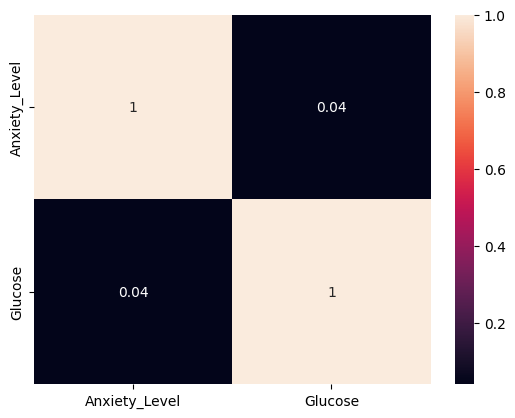

In [93]:
sns.heatmap(df.corr(), annot=True)
s

## Predictive Analysis

In [103]:
normal_G = df.loc[df['G_Level'] == 'in range' ]

lr_glucose = scipy.stats.linregress(x=normal_G['Glucose'], y=normal_G['Anxiety_Level'])
lr_glucose

LinregressResult(slope=0.0023728560881417548, intercept=0.8595169809177645, rvalue=0.03289880587424809, pvalue=0.6053920209195147, stderr=0.0045867770994551995, intercept_stderr=0.5538960432242618)

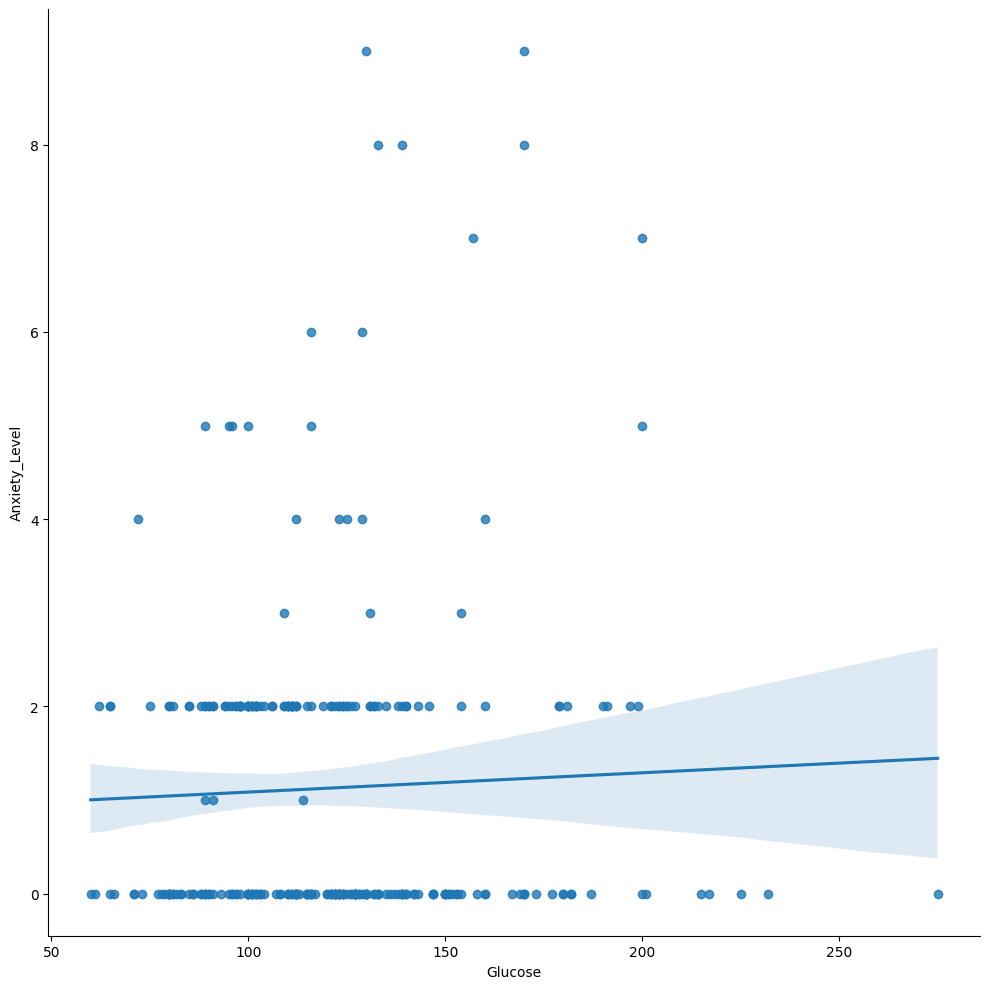

In [106]:
sns.lmplot(data=df, x='Glucose', y='Anxiety_Level', height=10)
s

In [117]:
df_mlr = df[['Glucose', 'Anxiety_Level', 'Mood', 'Register_DT']]

model_1 = (
    smf.ols(
        formula='Glucose ~ Anxiety_Level',
        data=df_mlr
    )
    .fit()
)

model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4531
Date:                Mon, 02 Jan 2023   Prob (F-statistic):              0.501
Time:                        20:13:10   Log-Likelihood:                -1386.1
No. Observations:                 282   AIC:                             2776.
Df Residuals:                     280   BIC:                             2783.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       120.0883      2.368     50.708      0.000     115.426     124.750
Anxiety_Level     0.7833      1.164      0.673      0.501      -1.507       3.074
==============================================================================
Omnibus:                       56.769   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.115
Skew:                           1.088   Prob(JB):                     1.10e-22
Kurtosis:                       4.967   Cond. No.                         2.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
model_2 = (
    smf.ols(
        formula='Glucose ~ Anxiety_Level + Mood',
        data=df_mlr
    )
    .fit()
)

model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.5783
Date:                Mon, 02 Jan 2023   Prob (F-statistic):              0.815
Time:                        20:16:15   Log-Likelihood:                -1383.6
No. Observations:                 282   AIC:                             2787.
Df Residuals:                     272   BIC:                             2824.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           117.5709     24.855      4.730      0.000      68.637     166.504
Mood[T.Anxious]      15.1452     27.458      0.552      0.582     -38.912      69.202
Mood[T.Hungry]        7.5236     33.405      0.225      0.822     -58.242      73.290
Mood[T.Motivated]   -22.8885     33.870     -0.676      0.500     -89.570      43.793
Mood[T.Normal]        4.8771     24.463      0.199      0.842     -43.284      53.038
Mood[T.Relaxed]      -0.5465     25.273     -0.022      0.983     -50.303      49.210
Mood[T.Sad]          23.5000     33.300      0.706      0.481     -42.058      89.058
Mood[T.Stress]       38.5709     34.238      1.127      0.261     -28.834     105.976
Mood[T.Tired]        -5.3727     27.546     -0.195      0.846     -59.604      48.859
Anxiety_Level        -0.6824      1.769     -0.386      0.700      -4.165       2.800
==============================================================================
Omnibus:                       56.222   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.244
Skew:                           1.077   Prob(JB):                     1.71e-22
Kurtosis:                       4.972   Cond. No.                         80.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
model_3 = (
    smf.ols(
        formula='Glucose ~ Anxiety_Level + Mood + Register_DT',
        data=df_mlr
    )
    .fit()
)

model_3.summary()

c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 02 Jan 2023   Prob (F-statistic):                nan
Time:                        20:16:20   Log-Likelihood:                 7566.5
No. Observations:                 282   AIC:                        -1.457e+04
Df Residuals:                       0   BIC:                        -1.354e+04
Df Model:                         281                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                         105.9553        inf          0        nan         nan         nan
Mood[T.Anxious]                                    16.4060        inf          0        nan         nan         nan
Mood[T.Hungry]                                      8.1872        inf          0        nan         nan         nan
Mood[T.Motivated]                                  -8.2773        inf         -0        nan         nan         nan
Mood[T.Normal]                                     16.0447        inf          0        nan         nan         nan
Mood[T.Relaxed]                                    10.6793        inf          0        nan         nan         nan
Mood[T.Sad]                                        19.9812        inf          0        nan         nan         nan
Mood[T.Stress]                                     26.5992        inf          0        nan         nan         nan
Mood[T.Tired]                                       3.3915        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-05 11:43:00')]   -19.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-06 00:45:00')]   -57.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-07 07:00:00')]     3.0787        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-08 00:30:00')]    13.3654        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-08 12:35:00')]   -27.9213        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-08 18:45:00')]   -11.9213        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-09 09:20:00')]   -25.9213        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-05 11:42:00')]   -22.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-05 22:12:00')]   -31.4607        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-06 08:00:00')]     5.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-06 22:30:00')]   -42.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-08 02:30:00')]   -15.6346        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-08 06:30:00')]    18.3654        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-08 12:13:00')]   -24.9213        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-09 08:35:00')]   -35.6346        i

In [126]:
model_4 = (
    smf.ols(
        formula='Glucose ~ Register_DT',
        data=df_mlr
    )
    .fit()
)

model_4.summary()

c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\statsmodels\regression\linear_model.py:1765: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Users\fchav\OneDrive\Documentos\Fer Mavec\projects\Project_DiabFer\venv\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Glucose   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 02 Jan 2023   Prob (F-statistic):                nan
Time:                        20:17:01   Log-Likelihood:                 7651.6
No. Observations:                 282   AIC:                        -1.474e+04
Df Residuals:                       0   BIC:                        -1.371e+04
Df Model:                         281                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                         122.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-05 11:43:00')]   -19.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-06 00:45:00')]   -57.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-07 07:00:00')]     4.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-08 00:30:00')]     8.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-08 12:35:00')]   -27.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-08 18:45:00')]   -11.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-01-09 09:20:00')]   -25.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-05 11:42:00')]   -22.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-05 22:12:00')]   -31.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-06 08:00:00')]     5.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-06 22:30:00')]   -42.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-08 02:30:00')]   -21.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-08 06:30:00')]    13.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-08 12:13:00')]   -24.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-09 08:35:00')]   -41.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-11 17:08:00')]   153.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-02-24 07:00:00')]   -16.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-03-06 02:00:00')]   -62.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-03-06 08:00:00')]    16.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-03-06 10:38:00')]   -56.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-03-08 10:56:00')]   -24.0000        inf         -0        nan         nan         nan
Register_DT[T.Timestamp('2022-03-09 19:34:00')]    57.0000        inf          0        nan         nan         nan
Register_DT[T.Timestamp('2022-03-11 12:41:00')]    31.0000        i

In [127]:
model_results = pd.DataFrame(
    dict(
        Register_DT = df.Register_DT,
        Mood = df.Mood,
        Anxiety_Level = df.Anxiety_Level,
        ActualValue = df.Glucose,
        PredictionM1 = model_1.predict(),
        PredictionM2 = model_2.predict(),
        PredictionM3 = model_3.predict(),
        PredictionM4 = model_4.predict()
    )
)

model_results

,Register_DT,Mood,Anxiety_Level,ActualValue,PredictionM1,PredictionM2,PredictionM3,PredictionM4
0,2022-03-16 19:08:00,Sad,4,160,123.221588,138.341208,160.0,160.0
1,2022-03-17 08:34:00,Normal,7,200,125.571544,117.671032,200.0,200.0
2,2022-03-17 17:56:00,Tired,4,125,123.221588,109.468502,125.0,125.0
3,2022-03-18 17:11:00,Tired,5,89,124.004907,108.786087,89.0,89.0
4,2022-03-18 20:00:00,Hungry,8,170,126.354862,119.635169,170.0,170.0
...,...,...,...,...,...,...,...,...
277,2022-11-30 07:01:00,Normal,0,124,120.088315,122.447941,124.0,124.0
278,2022-11-30 11:02:00,Normal,0,139,120.088315,122.447941,139.0,139.0
279,2022-11-30 13:16:00,Normal,0,158,120.088315,122.447941,158.0,158.0
280,2022-11-30 19:31:00,Normal,0,154,120.088315,122.447941,154.0,154.0


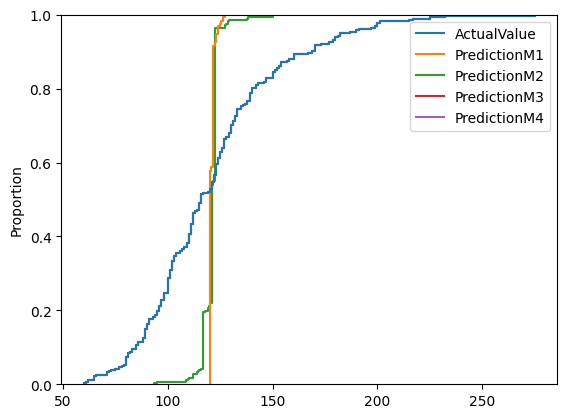

In [129]:
to_plot = model_results.loc[:,'ActualValue':]
sns.ecdfplot(data=to_plot)
s

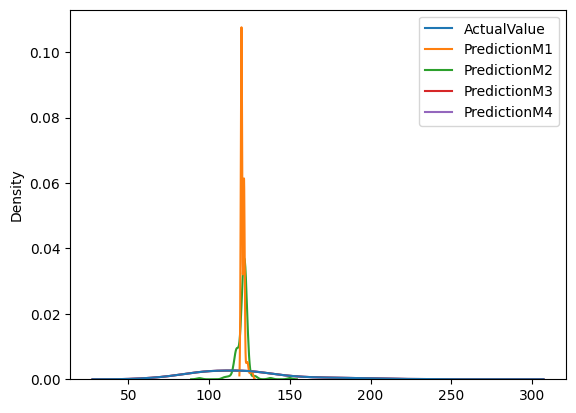

In [130]:
sns.kdeplot(data=to_plot)
s

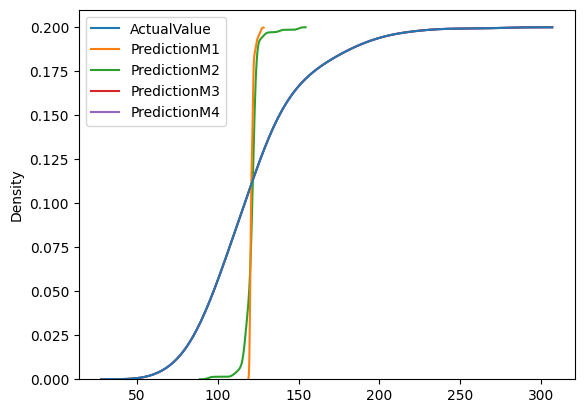

In [131]:
sns.kdeplot(data=to_plot, cumulative=True)
s